# 1. Prerequisites and Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

c:\Users\ADMIN\anaconda3\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Configuration
BASE_URL = "McAuley-Lab/Amazon-Reviews-2023"
CATEGORY = "All_Beauty"

RATINGS_URL = f"5core_rating_only_{CATEGORY}"
REVIEWS_URL = f"raw_review_{CATEGORY}"
METADATA_URL = f"raw_meta_{CATEGORY}"

# 2. Basic Dataset Checkup

In [3]:
def load_data(path):
    try: 
        data = load_dataset(BASE_URL, path)
        df = data["full"].to_pandas()
        return df
    except:
        print("Dataset loaded unsuccessfully.")

In [4]:
ratings_df = load_data(RATINGS_URL)
ratings_df.head(5)

,user_id,parent_asin,rating,timestamp
0,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07J3GH1W1,5.0,1547589356557
1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07W397QG4,5.0,1593352422858
2,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07KG1TWP5,5.0,1596473351088
3,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08JTNQFZY,5.0,1617904219785
4,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07SLFWZKN,3.0,1619737501209


In [5]:
reviews_df = load_data(REVIEWS_URL)
reviews_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [6]:
metadata_df = load_data(METADATA_URL)
metadata_df.head(5)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],None,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Howard Products,[],"{""Package Dimensions"": ""7.1 x 5.5 x 3 inches; ...",B01CUPMQZE,None,None,None
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Yes To,[],"{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Pro...",B076WQZGPM,None,None,None
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],None,"{'hi_res': [None, None], 'large': ['https://m....","{'title': [], 'url': [], 'user_id': []}",Levine Health Products,[],"{""Manufacturer"": ""Levine Health Products""}",B000B658RI,None,None,None
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Cherioll,[],"{""Brand"": ""Cherioll"", ""Item Form"": ""Powder"", ""...",B088FKY3VD,None,None,None
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Len...",[The Precision Plunger Bars are designed to wo...,None,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Precision,[],"{""UPC"": ""644287689178""}",B07NGFDN6G,None,None,None


In [7]:
# Shape inspection
print(f"5-core Ratings Shape: {ratings_df.shape}  (Rows = Interactions)")
print(f"Full Reviews Shape: {reviews_df.shape}  (Rows = Total Reviews)")
print(f"Metadata Shape: {metadata_df.shape} (Rows = Unique Products)")

5-core Ratings Shape: (2535, 4)  (Rows = Interactions)
Full Reviews Shape: (701528, 10)  (Rows = Total Reviews)
Metadata Shape: (112590, 16) (Rows = Unique Products)


In [8]:
# Check columns info 
ratings_df.info()
reviews_df.info()
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      2535 non-null   object
 1   parent_asin  2535 non-null   object
 2   rating       2535 non-null   object
 3   timestamp    2535 non-null   object
dtypes: object(4)
memory usage: 79.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701528 non-null  object 
 2   text               701528 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   h

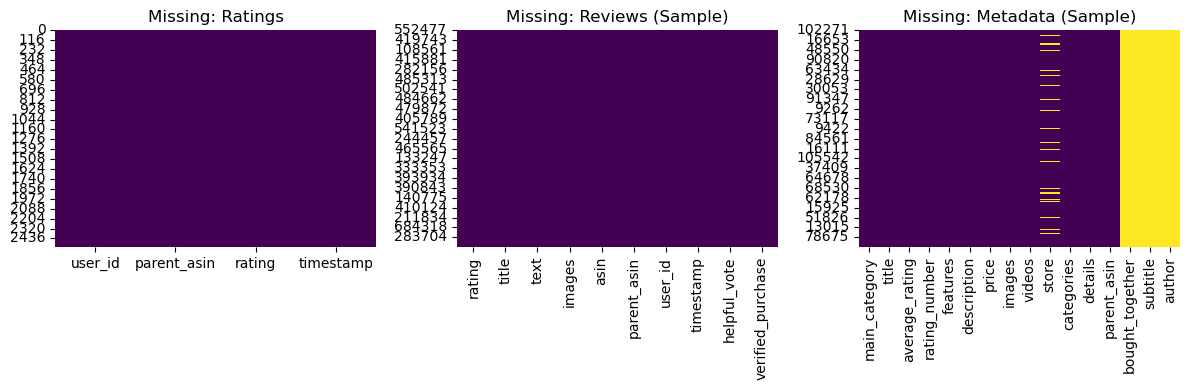

In [9]:
# Visualize missing data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.heatmap(ratings_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing: Ratings')

plt.subplot(1, 3, 2)
# Sample reviews if dataset is huge to prevent crash
sns.heatmap(reviews_df.sample(min(10000, len(reviews_df))).isnull(), cbar=False, cmap='viridis')
plt.title('Missing: Reviews (Sample)')

plt.subplot(1, 3, 3)
sns.heatmap(metadata_df.sample(min(10000, len(metadata_df))).isnull(), cbar=False, cmap='viridis')
plt.title('Missing: Metadata (Sample)')

plt.tight_layout()
plt.show()

In [10]:
# Check empty fields in images column 
def check_empty_images(val):
    if isinstance(val, list):
        return len(val) == 0
    return pd.isna(val)

empty_imgs_pct = metadata_df['images'].apply(check_empty_images).mean() * 100
print(f"\nPercentage of products with no images: {empty_imgs_pct:.2f}%")


Percentage of products with no images: 0.00%


In [11]:
# Check the overlapped data between dfs
# The ratings_df and metadat_df are joined on the key "parent_asin"

# First, we'll check the number of 5-core items present in the metadata
unique_items_5core = ratings_df['parent_asin'].unique()
unique_items_meta = set(metadata_df['parent_asin'].unique())
overlap_items = sum([1 for x in unique_items_5core if x in unique_items_meta])
item_coverage = (overlap_items / len(unique_items_5core)) * 100

print(f"Item Coverage: {item_coverage:.2f}% of 5-core items found in Metadata.")

Item Coverage: 100.00% of 5-core items found in Metadata.


In [12]:
# Second, we'll check the number of 5-core users present in the reviews data
unique_users_5core = ratings_df["parent_asin"].unique()
unique_users_reviews = set(reviews_df['parent_asin'].unique())
overlap_users = sum([1 for x in unique_users_5core if x in unique_users_reviews])
user_coverage = (overlap_users / len(unique_users_5core)) * 100

print(f"User Coverage: {user_coverage:.2f}% of 5-core users found in Reviews.")

User Coverage: 100.00% of 5-core users found in Reviews.


# 3. Ratings EDA

In [13]:
# Basic Counts
n_users = ratings_df['user_id'].nunique()
n_items = ratings_df['parent_asin'].nunique()
n_ratings = len(ratings_df)

print(f"Total Users: {n_users}")
print(f"Total Items: {n_items}")
print(f"Total Interactions: {n_ratings}")

Total Users: 253
Total Items: 356
Total Interactions: 2535


### 3.1 Interaction Distribution

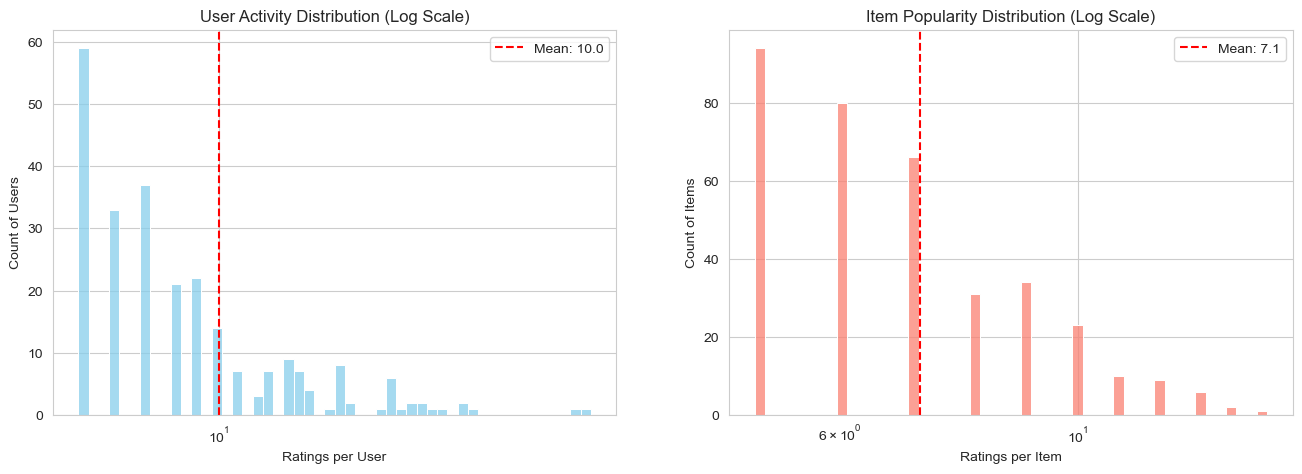

In [14]:
# Plotting Activity Distribution (Ratings per User & Ratings per Item)
# We use log-scale because the dataset is big and needs compressing for better visibility
user_activity = ratings_df.groupby('user_id')['parent_asin'].count()
item_popularity = ratings_df.groupby('parent_asin')['user_id'].count()

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# User Activity
sns.histplot(user_activity, bins=50, log_scale=True, ax=ax[0], color='skyblue')
ax[0].set_title('User Activity Distribution (Log Scale)')
ax[0].set_xlabel('Ratings per User')
ax[0].set_ylabel('Count of Users')
ax[0].axvline(user_activity.mean(), color='r', linestyle='--', label=f'Mean: {user_activity.mean():.1f}')
ax[0].legend()

# Item Popularity
sns.histplot(item_popularity, bins=50, log_scale=True, ax=ax[1], color='salmon')
ax[1].set_title('Item Popularity Distribution (Log Scale)')
ax[1].set_xlabel('Ratings per Item')
ax[1].set_ylabel('Count of Items')
ax[1].axvline(item_popularity.mean(), color='r', linestyle='--', label=f'Mean: {item_popularity.mean():.1f}')
ax[1].legend()

plt.show()

**Comment**:
- The distribution of user activity is highly skewed, with the majority of users contributing only a small number of reviews. Most users rate between 1 and 5 items, while a much smaller group of users contribute significantly more. The long right tail indicates that a few users provide dozens or even hundreds of ratings.
- Item popularity shows a similarly long-tailed distribution. Most items receive only a handful of ratings, while a small number of popular or trending items attract a disproportionately large number of reviews.

### 3.2 Temporal Patterns

This checks if the data has time-based biases (seasonality) or trends (platform growth).

In [15]:
# Convert timestamp to datetime
ratings_df['date'] = pd.to_datetime(ratings_df['timestamp'], unit='ms')
ratings_df['year_month'] = ratings_df['date'].dt.to_period('M')

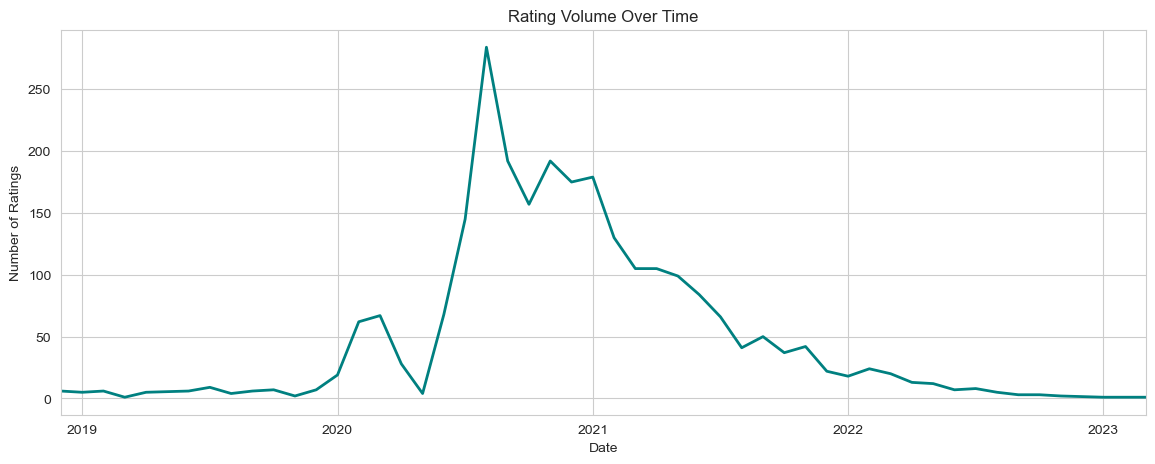

In [16]:
# Visualize Rating Volumne Over Time
monthly_counts = ratings_df.groupby('year_month').size()

plt.figure(figsize=(14, 5))
monthly_counts.plot(kind='line', color='teal', linewidth=2)
plt.title('Rating Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

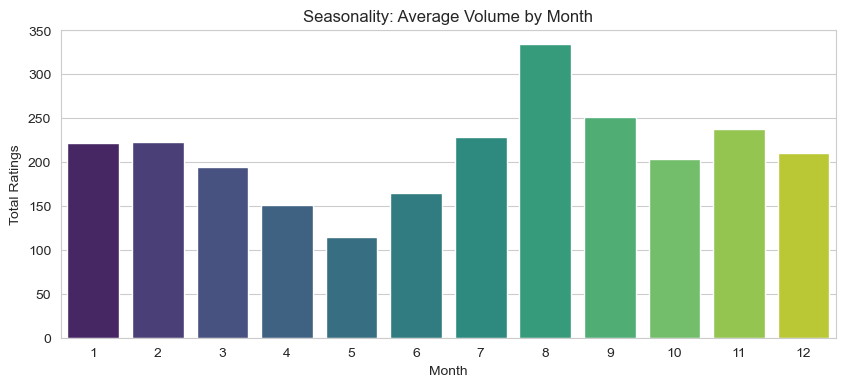

In [17]:
# Analyze Seasonality
ratings_df['month'] = ratings_df['date'].dt.month
seasonal_counts = ratings_df.groupby('month').size()

plt.figure(figsize=(10, 4))
sns.barplot(x=seasonal_counts.index, y=seasonal_counts.values, palette='viridis')
plt.title('Seasonality: Average Volume by Month')
plt.xlabel('Month')
plt.ylabel('Total Ratings')
plt.show()

### 3.3 Rating Distribution

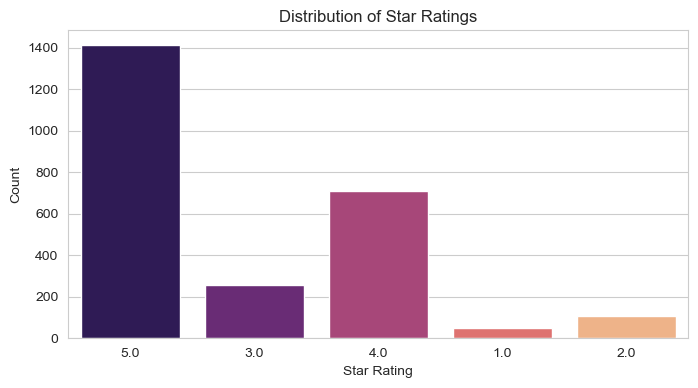

In [18]:
# Plot Histogram
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=ratings_df, palette='magma')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

In [19]:
ratings_df['rating'] = pd.to_numeric(ratings_df['rating'], errors='coerce')

mean_rating = ratings_df['rating'].mean()
print(f"Global Average Rating: {mean_rating:.2f}")

Global Average Rating: 4.31


# 4. Textual Reviews EDA

### 4.1 Text Length Statistics

In [20]:
# Ensure text columns are strings
reviews_df['text'] = reviews_df['text'].fillna('').astype(str)
reviews_df['title'] = reviews_df['title'].fillna('').astype(str)

In [21]:
# Compute lengths
reviews_df['char_count'] = reviews_df['text'].apply(len)
# Approximate token count by splitting on whitespace
reviews_df['word_count'] = reviews_df['text'].apply(lambda x: len(x.split()))

print(reviews_df[['char_count', 'word_count']].describe())

          char_count     word_count
count  701528.000000  701528.000000
mean      173.031641      32.750720
std       246.924645      45.973273
min         0.000000       0.000000
25%        44.000000       8.000000
50%       102.000000      19.000000
75%       209.000000      40.000000
max     14989.000000    2585.000000


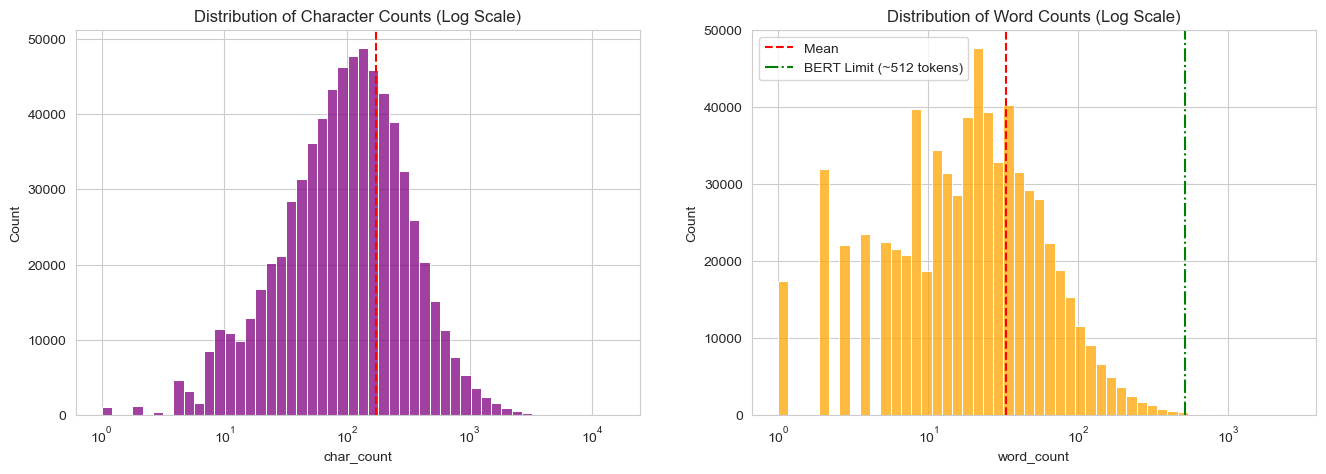

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Character Count (Log scale often helps with skewed data)
sns.histplot(reviews_df['char_count'], bins=50, log_scale=True, ax=ax[0], color='purple')
ax[0].set_title('Distribution of Character Counts (Log Scale)')
ax[0].axvline(reviews_df['char_count'].mean(), color='r', linestyle='--', label='Mean')

# Word Count
sns.histplot(reviews_df['word_count'], bins=50, log_scale=True, ax=ax[1], color='orange')
ax[1].set_title('Distribution of Word Counts (Log Scale)')
ax[1].axvline(reviews_df['word_count'].mean(), color='r', linestyle='--', label='Mean')
ax[1].axvline(512, color='g', linestyle='-.', label='BERT Limit (~512 tokens)')

plt.legend()
plt.show()

In [23]:
long_reviews = reviews_df[reviews_df['word_count'] > 500].shape[0]
print(f"Reviews exceeding standard BERT limit (~500 words): {long_reviews} ({long_reviews/len(reviews_df)*100:.2f}%)")

Reviews exceeding standard BERT limit (~500 words): 534 (0.08%)


### 4.2 Text Quality and Noise Detection

In [24]:
# Users sometimes double-click submit, or bots post identical spam.
duplicates = reviews_df.duplicated(subset=['text']).sum()
print(f"Duplicate Review Texts: {duplicates} ({duplicates/len(reviews_df)*100:.2f}%)")

Duplicate Review Texts: 57899 (8.25%)


In [25]:
# Identify Low Content Reviews
# Reviews like "Good", "Ok", "Nice" are not useful for embedding models.
short_reviews = reviews_df[reviews_df['word_count'] < 3]
print(f"Very Short Reviews (< 3 words): {len(short_reviews)} ({len(short_reviews)/len(reviews_df)*100:.2f}%)")

# View top short reviews
print("\nMost common short reviews:")
print(short_reviews['text'].value_counts().head(10))

Very Short Reviews (< 3 words): 50058 (7.14%)

Most common short reviews:
text
Love it          1651
Good             1479
Great            1257
Great product    1087
Nice              688
Love it!          662
Perfect           630
                  613
good              561
Good product      540
Name: count, dtype: int64


In [26]:
empty_text = reviews_df[reviews_df['text'].str.strip() == ''].shape[0]
print(f"Empty/Whitespace-only Reviews: {empty_text}")

Empty/Whitespace-only Reviews: 720


### 4.3 Sentiment Analysis

In [27]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

reviews_df['sentiment'] = reviews_df['text'].apply(get_sentiment)

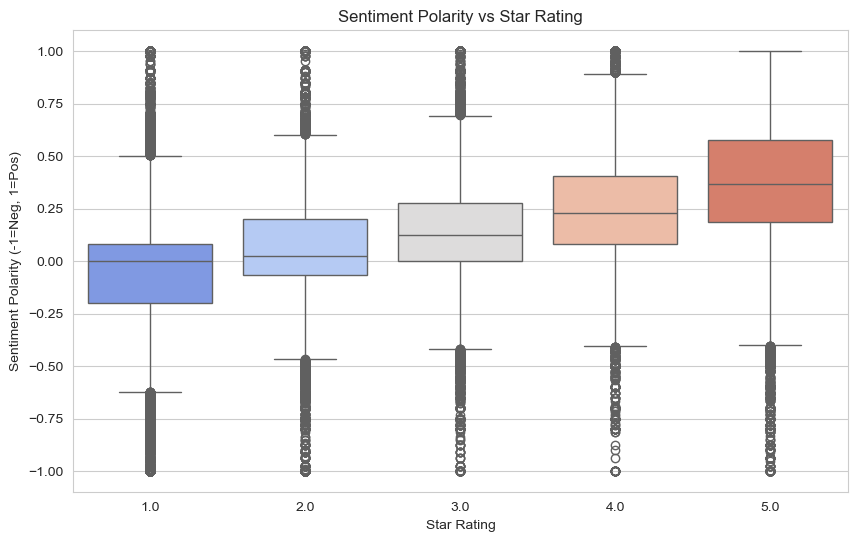

In [28]:
# Plot Sentiment vs Rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='sentiment', data=reviews_df, palette='coolwarm')
plt.title('Sentiment Polarity vs Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Polarity (-1=Neg, 1=Pos)')
plt.show()

In [29]:
# Detect Mismatches (Sarcasm or Error)
# High Rating (5) but Negative Sentiment (< -0.5)
mismatches = reviews_df[(reviews_df['rating'] == 5) & (reviews_df['sentiment'] < -0.5)]
print(f"Potential Mismatches found (5-star but negative text): {len(mismatches)}")

if len(mismatches) > 0:
    print(mismatches[['rating', 'sentiment', 'text']].head(3))

Potential Mismatches found (5-star but negative text): 456
      rating  sentiment                                               text
3548     5.0  -0.800000                   Used as a base for e-cigarettes.
4924     5.0  -0.714286  Waves make people sea sick from looking at my ...
8750     5.0  -0.700000            My feet sweats badly and it helps them.


In [30]:
# Again, Detect Mismatches, but this time with Low Rating but Positive Sentiment 
mismatches_again = reviews_df[(reviews_df['rating'] == 1) & (reviews_df['sentiment'] > 0.5)]
print(f"Potential Mismatches found (1-star but positive text): {len(mismatches)}")

if len(mismatches_again) > 0:
    print(mismatches_again[['rating', 'sentiment', 'text']].head(3))

Potential Mismatches found (1-star but positive text): 456
      rating  sentiment                                               text
1210     1.0      0.625  So Cheap! They Melt & Snap Apart as Soon as Th...
1967     1.0      1.000  These sold for 9.00 during closeout on perfect...
2137     1.0      0.800  They would not work for me<br />I had to give ...


### 4.4 Language Check

In [31]:
# Language Check (Basic check for non-ASCII characters)
def has_non_ascii(text):
    return not all(ord(c) < 128 for c in text)

non_english_chars = reviews_df['text'].apply(has_non_ascii).sum()
print(f"\nReviews with non-ASCII characters (potential non-English/Emojis): {non_english_chars} ({non_english_chars/len(reviews_df)*100:.2f}%)")


Reviews with non-ASCII characters (potential non-English/Emojis): 104044 (14.83%)
